In [1]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model, make_mlp_model, make_vi_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from xgbse.non_parametric import calculate_kaplan_vectorized
from utility.survival import get_breslow_survival_times, compute_survival_times, compute_survival_scale

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

MLP_RUNS = 1
VI_RUNS = 100
MCD_RUNS = 100

# Load config
config = load_config(pt.MLP_CONFIGS_DIR, f"SEER.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
custom_objects = {"CoxPHLoss": CoxPHLoss()}
with tf.keras.utils.custom_object_scope(custom_objects):
    loss_fn = tf.keras.losses.deserialize(config['loss_fn'])
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
l2_reg = config['l2_reg']
batch_size = config['batch_size']

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Create model instances
mlp_model = make_mlp_model(input_shape=X_train.shape[1:], output_dim=1,
                           layers=layers, activation_fn=activation_fn,
                           dropout_rate=dropout_rate, regularization_pen=l2_reg)
vi_model = make_vi_model(n_train_samples=X_train.shape[0],
                         input_shape=X_train.shape[1:], output_dim=2,
                         layers=layers, activation_fn=activation_fn,
                         dropout_rate=dropout_rate, regularization_pen=l2_reg)
mcd_model = make_mcd_model(input_shape=X_train.shape[1:], output_dim=2,
                       layers=layers, activation_fn=activation_fn,
                       dropout_rate=dropout_rate, regularization_pen=l2_reg)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
mlp_model.load_weights(f'{root_dir}/models/seer_mlp')
vi_model.load_weights(f'{root_dir}/models/seer_vi')
mcd_model.load_weights(f'{root_dir}/models/seer_mcd')

optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95, weight_decay=0.95)
loss_fn = CoxPHLoss()
mlp_model.compile(loss=loss_fn, optimizer=optimizer)
vi_model.compile(loss=loss_fn, optimizer=optimizer)
mcd_model.compile(loss=loss_fn, optimizer=optimizer)

c:\Users\au475271\Miniconda3\envs\py38-bayes-surv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
`layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.


In [2]:
from tools.model_builder import make_cox_model, make_mlp_model
from utility.survival import compute_survival_times_with_censoring

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

In [9]:
n_samples = 100
obs_index = 1
X_test_sample = np.expand_dims(np.array(X_test.iloc[obs_index]), axis=0)
pred = np.reshape(mlp_model.predict(X_test_sample, verbose=0), 1)
mlp_scale = compute_survival_scale(pred, t_train, e_train)

mcd_scale = np.zeros((n_samples, 1))
for i in range(0, n_samples):
    pred = np.reshape(mcd_model.predict(X_test_sample, verbose=0), 1)
    mcd_scale[i,:] = compute_survival_scale(pred, t_train, e_train)
mcd_scale = mcd_scale.flatten()



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



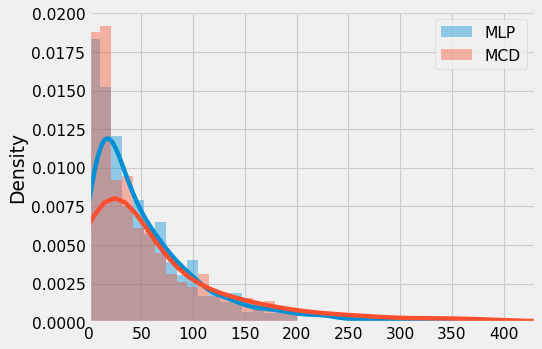

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(dpi=80)
hist_bins = np.linspace(0, 200, 20)
sns.distplot(mlp_cpd_st, kde=True, bins=hist_bins, label="MLP").set(xlim=(0))
sns.distplot(mcd_cpd_st, kde=True, bins=hist_bins, label="MCD")
plt.legend()
plt.show()

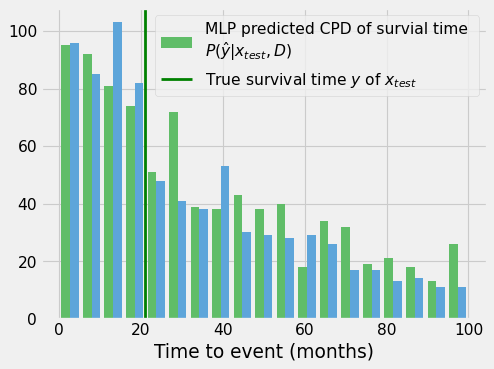

In [ ]:
import seaborn as sns
HIST_BINS = np.linspace(0, 100, 20)
plt.figure(dpi=80)
sns.histplot


plt.hist([mlp_cpd_st.flatten(), mcd_cpd_st.flatten()], bins=HIST_BINS, color=[TFColor[2], TFColor[3]], 
             label="MLP predicted CPD of survial time \n$P(\hat{y}|x_{test}, D)$", alpha=1)
plt.axvline(x=y_test['time'][obs_index], color='g', linewidth=2.5, label="True survival time $y$ of $x_{test}$") # TODO: Use y
plt.xlabel("Time to event (months)")
plt.legend()
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_pred_cpd_mcd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

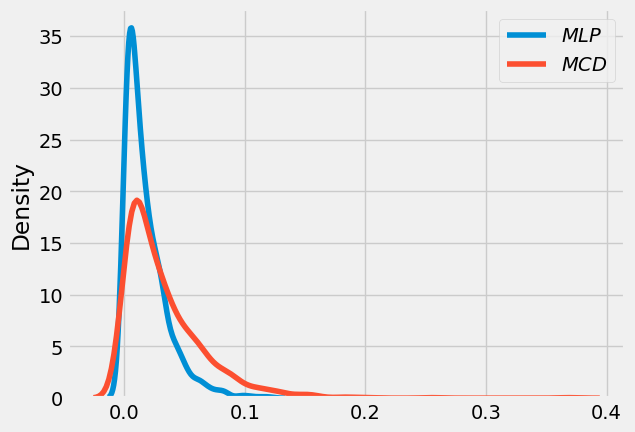

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#fixing the seed for reproducibility
#of the result
np.random.seed(10)

t = np.linspace(0, 100)
y = mlp_scale * np.exp(-mlp_scale*t)

size = 1000
#plotting 1000 sample from 
#different exponential distribution
sns.kdeplot(np.random.exponential(mlp_scale, size))
sns.kdeplot(np.random.exponential(mcd_scale[0], size))

plt.legend([r"$MLP$", r"$MCD$"])
plt.show()

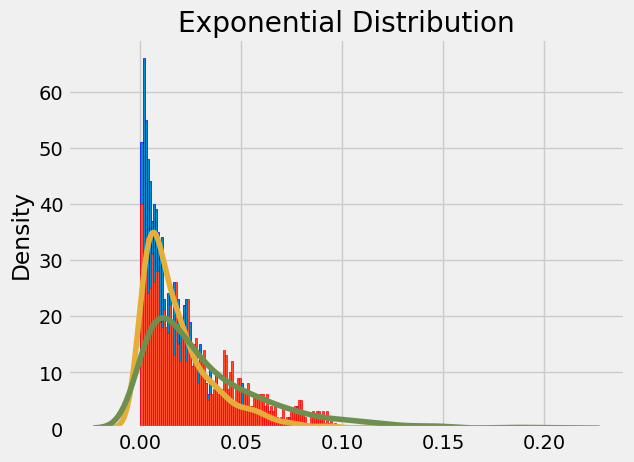

In [27]:
mlp_sample = np.random.exponential(mlp_scale, size)
mcd_sample = np.random.exponential(mcd_scale[0], size)
bin = np.arange(0, 0.1, 0.001)

plt.hist(mlp_sample, bins=bin, edgecolor='blue')
plt.hist(mcd_sample, bins=bin, edgecolor='red') 
plt.title("Exponential Distribution") 
sns.kdeplot(np.random.exponential(mlp_scale, size))
sns.kdeplot(np.random.exponential(mcd_scale[0], size))
plt.show()

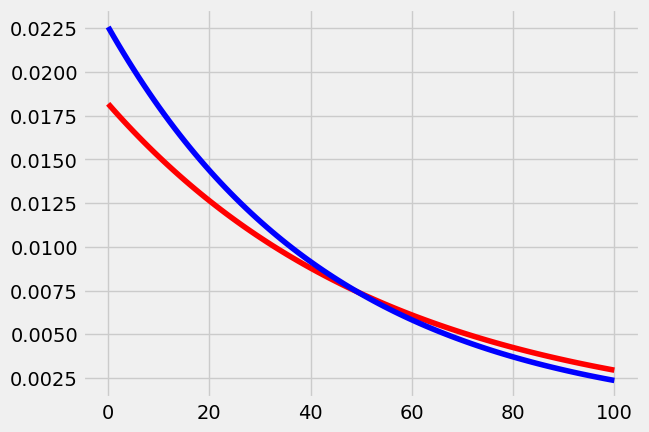

In [88]:
t = np.linspace(0, 400, 100)
n_samples = 100
obs_index = 1
X_test_sample = np.expand_dims(np.array(X_test.iloc[obs_index]), axis=0)
pred = np.reshape(mlp_model.predict(X_test_sample, verbose=0), 1)
mlp_scale = compute_survival_scale(pred, t_train, e_train)

mcd_scale = np.zeros((n_samples, 1))
for i in range(0, n_samples):
    pred = np.reshape(mcd_model.predict(X_test_sample, verbose=0), 1)
    mcd_scale[i,:] = compute_survival_scale(pred, t_train, e_train)
mcd_scale = mcd_scale.flatten()

mlp_y = mlp_scale * np.exp(-mlp_scale*t)
mcd_y = mcd_scale.mean() * np.exp(-mcd_scale.mean()*t)

plt.plot(t, mlp_y, color="red")
plt.plot(t, mcd_y, color="blue")

In [4]:
n_samples = 5000
obs_index = 1
t = np.linspace(0, 400, 100)

X_test_sample = np.expand_dims(np.array(X_test.iloc[obs_index]), axis=0)
pred = np.reshape(mlp_model.predict(X_test_sample, verbose=0), 1)
mlp_scale = compute_survival_scale(pred, t_train, e_train)
mlp_y = mlp_scale * np.exp(-mlp_scale*t)

mcd_scale = np.zeros((n_samples, 1))
for i in range(0, n_samples):
    pred = np.reshape(mcd_model.predict(X_test_sample, verbose=0), 1)
    mcd_scale[i,:] = compute_survival_scale(pred, t_train, e_train)
mcd_scale = mcd_scale.flatten()

mlp_y = mlp_scale * np.exp(-mlp_scale*t)
mcd_y = mcd_scale.mean() * np.exp(-mcd_scale.mean()*t)

samples = np.zeros((n_samples, 1))
for i in range(n_samples):
    y_sample = np.random.exponential(1/mcd_scale[i], 1)
    samples[i] = y_sample
samples = samples.flatten()

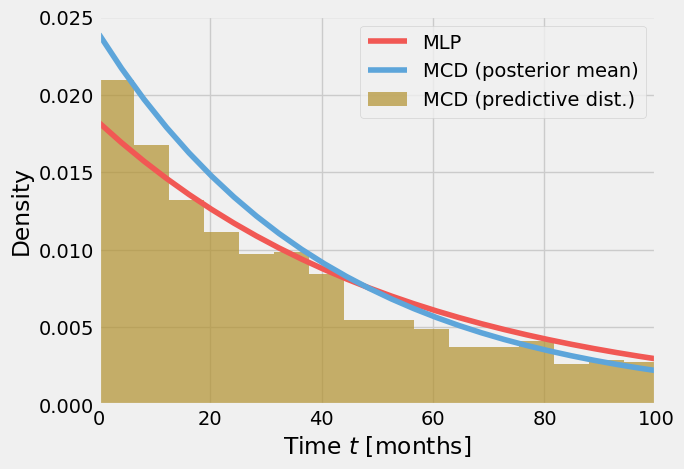

In [7]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)

plt.plot(t, mlp_y, color=TFColor[0], label="MLP")
plt.plot(t, mcd_y, color=TFColor[3], label="MCD (posterior mean)")
plt.hist(samples, color=TFColor[5], density=True, bins=250, alpha=0.7, label="MCD (predictive dist.)")
plt.xlim(0, 100)
plt.ylabel('Density')
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"seer_surv_pdf.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()
# the density of exp samples of random parameters